In [144]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame
import utils as ut

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

In [78]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

health_df = concat_data('../data/san_francisco/')
health_df.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_12028/1640379659.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [79]:
# Turn into a TwitterDataFrame and zoom in on san francisco
health_df = TwitterDataFrame(health_df)
lat = (37, 39)
lon = (-121, -124)
sf_df_raw = health_df.zoom_in(lat, lon)

In [80]:
# Take a random subsample of the dataframe to reduce the size
sf_df_raw = sf_df_raw.sample(32000, replace=True)

# Ideally this should be before sampling but this way saves time
# Could this happen in TwitterDataFrame?
sf_df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df_raw['created_at']]

# Subset 5/2018-12/2018
sf_df_raw = sf_df_raw[sf_df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
sf_df_raw['date'] = sf_df_raw['created_at'].dt.floor('d')

sf_df = TwitterDataFrame(sf_df_raw)
sf_df.head()

,id,author_id,text,geo,created_at,lat,lon,date
182237,993868419308007424,987933978,So very congested today.. I didn't sleep very ...,{'place_id': '5ecbd073f39c00fa'},2018-05-08 15:01:11,37.592632,-122.160814,2018-05-08
24109,1045443863505072128,385251676,Man did you see the disdain on Judge Kavenaugh...,{'place_id': '5a110d312052166f'},2018-09-27 22:43:35,37.708075,-122.514926,2018-09-27
57707,1044009348463091713,119524229,Bear 🐻 WIN Bear WIN #BearDown,{'place_id': '6a71821001635bbd'},2018-09-23 23:43:20,37.649122,-122.500164,2018-09-23
107953,1019028177023143937,15469541,@roelofbotha Regulations are reactions from th...,{'place_id': 'a409256339a7c6a1'},2018-07-17 01:17:04,37.443954,-122.288530,2018-07-17
54456,1032839300444971009,2405043516,I really wanna do a Mukbang lol,{'place_id': '1a5fd1b93128bb9e'},2018-08-24 03:57:33,37.678709,-122.130814,2018-08-24


In [81]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  25793
Per day : 70.66575342465754


Text(0.5, 0, 'Date')

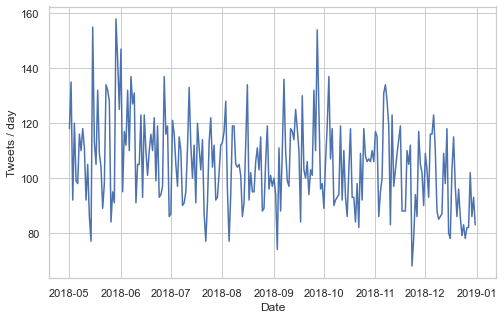

In [82]:
# Plot num tweets per day by date
plt.figure(figsize=(8,5))
plt.plot(sf_df.count_by_day())
ax = plt.gca()
ax.set_ylabel("Tweets / day")
ax.set_xlabel("Date")

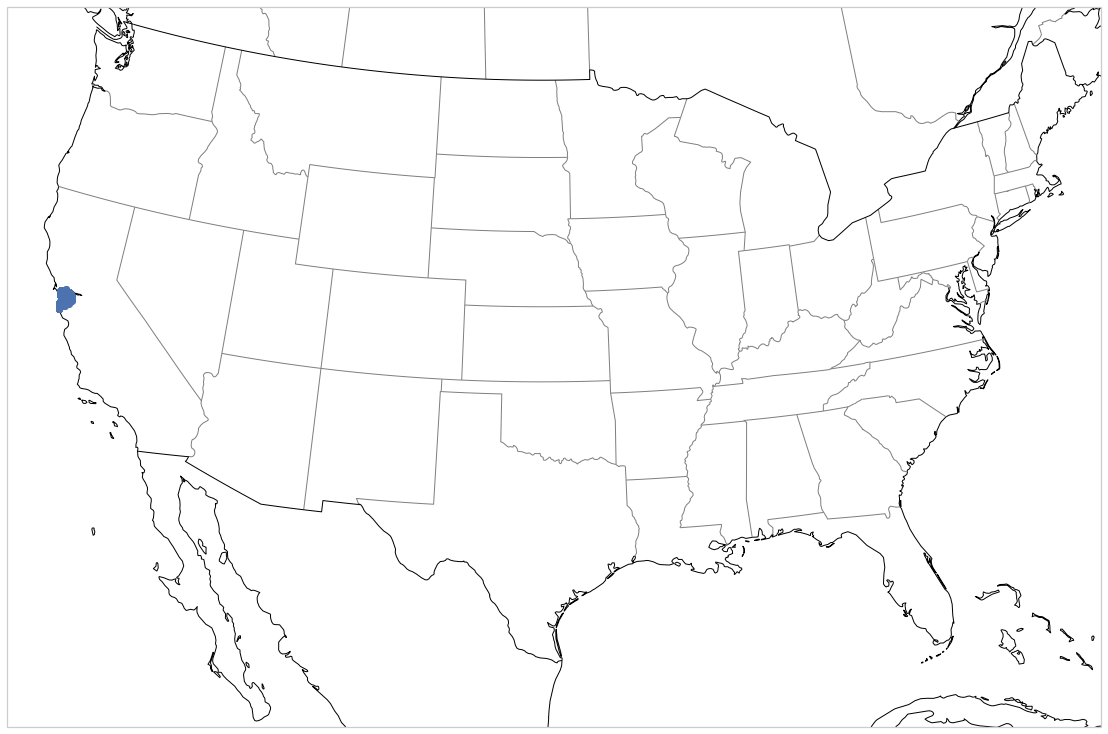

In [83]:
import cartopy
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection=cartopy.crs.LambertConformal(central_longitude=-98.0))
ax.set_extent((-120, -75,21, 50), cartopy.crs.Geodetic())
ax.coastlines()

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS)
ax.scatter(sf_df['lon'],sf_df['lat'], transform=cartopy.crs.PlateCarree())
# plt.show()

In [84]:
# Read in the daily AQI in 2018 California
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

# Subset just SF country and extract dates
sf_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])

sf_aqi.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_12028/2893133138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


</br>
</br>
</br>

## Experiment 1: Predicting AQI with individual tweets
----

In [85]:
# Merge AQI and tweet dateframes
sf_mrg = pd.merge(left=sf_df, right=sf_aqi, left_on='date', right_on='Date', how='inner')

# extract our regression variables
X = sf_mrg['text']
y = sf_mrg['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

sf_mrg.head()

,id,author_id,text,geo,created_at,lat,lon,date,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,993868419308007424,987933978,So very congested today.. I didn't sleep very ...,{'place_id': '5ecbd073f39c00fa'},2018-05-08 15:01:11,37.592632,-122.160814,2018-05-08,California,San Francisco,6,75,2018-05-08,27,Good,Ozone,06-075-0005,1
1,993980559679410177,852730009928073216,mood: when you’re too poor to fix your ratchet...,{'place_id': '26b9557935d73cba'},2018-05-08 22:26:47,37.881262,-122.327841,2018-05-08,California,San Francisco,6,75,2018-05-08,27,Good,Ozone,06-075-0005,1
2,993860106033872897,248989689,@fader_jacob @jitotweets I mean I’m pretty sur...,{'place_id': '987731fa5d6db2ba'},2018-05-08 14:28:08,37.850036,-122.167768,2018-05-08,California,San Francisco,6,75,2018-05-08,27,Good,Ozone,06-075-0005,1
3,993730338927988737,301058260,Thanks to @Uber and their Uberpool system I’ve...,{'place_id': '9cee92fec370baf9'},2018-05-08 05:52:30,37.568111,-122.403936,2018-05-08,California,San Francisco,6,75,2018-05-08,27,Good,Ozone,06-075-0005,1
4,993689417259794433,17821726,"@KellyannePolls Is that supposed to be poetic,...",{'place_id': 'ab2f2fac83aa388d'},2018-05-08 03:09:53,37.699279,-122.342660,2018-05-08,California,San Francisco,6,75,2018-05-08,27,Good,Ozone,06-075-0005,1


In [86]:
X_train.shape, y_train.shape

((20634,), (20634,))

In [164]:
# Text regression pipeline
def train_model(X_train, y_train, X_test, y_test, params=(100, 5)):
    n_dim, k = params

    # Vectorize tweets
    tf_vect = TfidfVectorizer(min_df=1, stop_words="english").fit(X_train)
    X_enc = tf_vect.transform(X_train)
    X_test_enc = tf_vect.transform(X_test)
    
    # Run trunvated SVD on the vector encodings
    svd_model = TruncatedSVD(n_components=n_dim, random_state=23).fit(X_enc)
    X_lsa = svd_model.transform(X_enc)
    X_test_lsa = svd_model.transform(X_test_enc)

    # Fit Regression model
    knn_model = KNeighborsRegressor(k).fit(X_lsa, y_train)
    y_pred = knn_model.predict(X_lsa)

    return svd_model, knn_model, X_lsa, y_pred, X_test_lsa


In [ ]:
svd_model, knn_model, X_lsa, y_pred, X_test_lsa = train_model(X_train, y_train, X_test, y_test)
X_lsa.shape, knn_model.score(X_lsa, y_train)

Text(0.5, 1.0, 'First Two Dimensions of SVD Encoding')

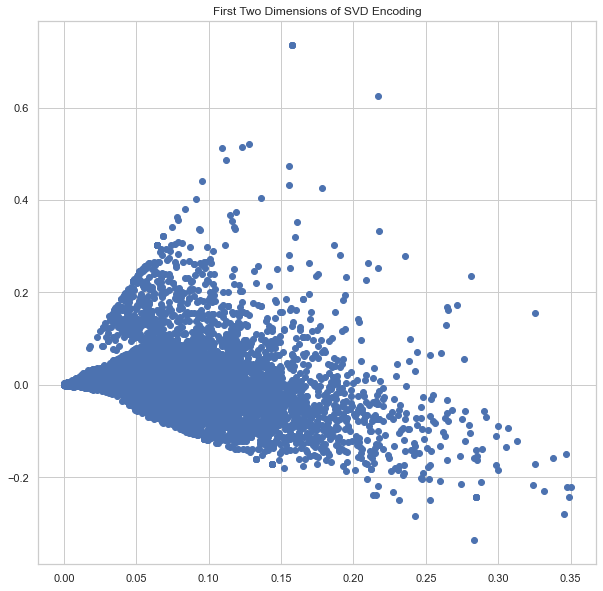

In [88]:
# Scatter the results
plt.scatter(X_lsa[:, 0], X_lsa[:, 1])
plt.title("First Two Dimensions of SVD Encoding")

Text(0.5, 0, 'Low Dimension tweet')

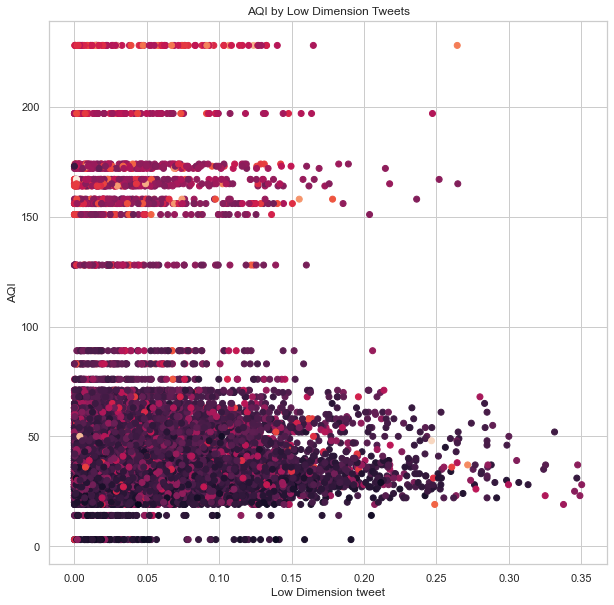

In [89]:
# plot scatterplot and linear model using predictions
plt.scatter(X_lsa[:, 0], y_train, c=y_pred)

plt.title("AQI by Low Dimension Tweets")
plt.ylabel("AQI", fontsize = 12)
plt.xlabel("Low Dimension tweet", fontsize = 12)

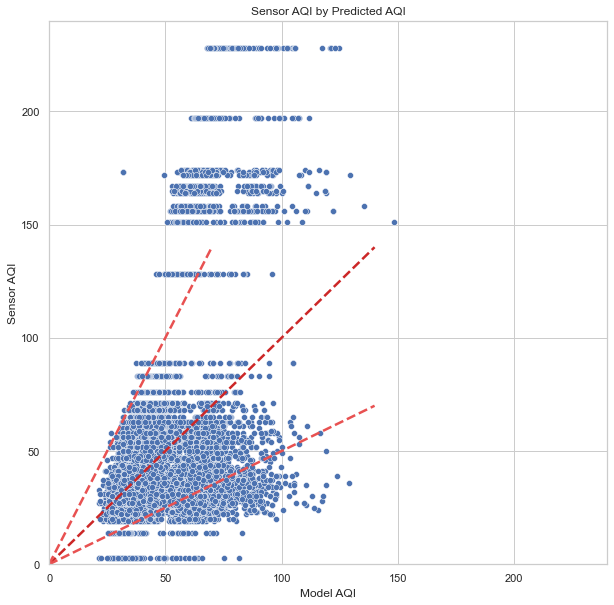

In [139]:
# Plots predictions by their true value
def plot_reference(y_pred, y_train):
    plot = sns.scatterplot(x=y_pred, y=y_train)

    # Draw reference lines
    X = np.linspace(0, 140, 140)
    plt.plot(X, X, '--', color="#cc2727", linewidth=2.5)
    plt.plot(X, X/2, '--', color="#e85151", linewidth=2.5)
    plt.plot(X/2, X, '--', color="#e85151", linewidth=2.5)

    # Set plot style
    plot.set(ylim=(0, 240))
    plot.set(xlim=(0,240))

    plot.set_title("Sensor AQI by Predicted AQI")
    plot.set_ylabel("Sensor AQI", fontsize = 12)
    plot.set_xlabel("Model AQI", fontsize = 12)

plot_reference(y_pred, y_train)

</br>
</br>
</br>

## Experiment 2: Predicting AQI with tweets grouped by day  
----

In [158]:
# Group tweets by day before merging
sf_df_days = sf_df.group_by_day()

# Merge AQI and tweet dateframes
sf_mrg_days = pd.merge(left=sf_df_days, right=sf_aqi, left_on='date', right_on='Date', how='inner')

# extract our regression variables
X_days = sf_mrg_days['text']
y_days = sf_mrg_days['AQI']

X_train_days, X_test_days, y_train_days, y_test_days = train_test_split(X_days, y_days, test_size=0.2, random_state=23)

sf_mrg_days.head()

,text,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,@LottjrRichard They killed it! @MeganHoliday H...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
1,Harvard's doing a good job defending Gyimah. 3...,California,San Francisco,6,75,2018-05-02,36,Good,Ozone,06-075-0005,1
2,@A1Trisha Slap “blessed the broken road” .... ...,California,San Francisco,6,75,2018-05-03,36,Good,Ozone,06-075-0005,1
3,@mowseler @Silcris88 @PIPeJTV miss you :c @Gli...,California,San Francisco,6,75,2018-05-04,33,Good,Ozone,06-075-0005,1
4,Wake up call Warriors. Better win next game. @...,California,San Francisco,6,75,2018-05-05,37,Good,Ozone,06-075-0005,1


In [159]:
X_train_days.shape, y_train_days.shape

((196,), (196,))

In [168]:
svd_model_days, knn_model_days, X_lsa_days, y_pred_days, X_test_lsa_days = train_model(X_train_days, y_train_days, X_test_days, y_test_days, (10000, 5))
X_lsa_days.shape, knn_model_days.score(X_lsa_days, y_train_days)

((196, 196), 0.47539195220960784)

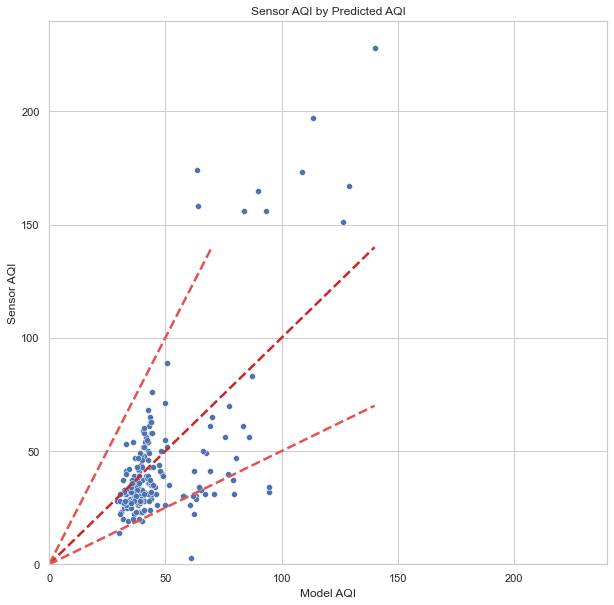

In [169]:
plot_reference(y_pred_days, y_train_days)

</br>
</br>
</br>

## Experiment 3: Predicting (classifying) AQI outliers by tweets grouped by day
----

In [174]:
X_test_days.shape, X_test_lsa_days.shape, y_test_days.shape

((49,), (49, 196), (49,), (196, 196))

In [177]:
y_train_clf = y_train_days > 150
y_test_clf = y_test_days > 150

model_clf = RandomForestClassifier().fit(X_lsa_days, y_train_clf)
model_clf.score(X_test_lsa_days, y_test_clf)

0.9591836734693877